# Mugration Analysis

## Setup
---

### Module Imports

In [1]:
from Bio import Phylo
from treetime.utils import parse_dates
from treetime import wrappers

import copy
import os
import sys
import IPython

import pandas as pd
import numpy as np
import math

from geopy.distance import great_circle

import matplotlib.pyplot as plt
from matplotlib import colors, lines, patches, gridspec
import seaborn as sns

### Input File Paths

In [2]:
'''
tree_path = str(snakemake.input.tree)
aln_path = str(snakemake.input.snp_aln)
metadata_path = str(snakemake.input.metadata)
treetime_path = str(snakemake.output.treetime)
'''
tree_path = "../../docs/results/2020-11-09/iqtree/iqtree-core_chromosome.filter5.treefile"
metadata_path = "../../docs/results/2020-12-08/metadata/metadata.txt"
outdir = "../../docs/results/2021-01-05/treetime/"

### Constants and Variables

In [51]:
# Metadata
NAME_COL = "Sample"
DATES_COL = "Date"
#ATTRIBUTE = "Country"
ATTRIBUTE = "Province"
#ATTRIBUTE = "Biovar"
NO_DATA_CHAR = "NA"

# Optional, lat, lon
ATTRIBUTE_LAT = ATTRIBUTE + "Lat"
ATTRIBUTE_LON = ATTRIBUTE + "Lon"
DIST_UNIT = "km"

# Confidence Thresholds
ALRT_THRESH = 80
UFBOOT_THRESH = 95
MUG_CONF_THRESH = 0.90
# Regression confidence interval
CI_VAL = 90
CI_BOOT = 100

### Global Plot Config

In [4]:
# Colors
HIGH_COL = "red"
LOW_COL = "black"
TERM_COL = "grey"
THRESH_COL = "blue"
COLOR_PAL = "rainbow"
COLBAR_MAX_ROW = 10

# Graphics
figsize=(6.4,4.8)
figsize_alt=(9.6,4.8)
dpi=400

# Font
SM_FONT = 5
MED_FONT = 8
LG_FONT = 10

plt.rc('font', size=SM_FONT)          # controls default text sizes
plt.rc('figure', titlesize=LG_FONT)  # fontsize of the figure title
#plt.rc('axes', labelsize=MED_FONT)    # fontsize of the x and y labels

# Lines
plt.rc('lines', linewidth=1)

## Branch Support Analysis

---

### Convert newick tree to temporary XML

In [5]:
tmp_xml = os.path.join(os.path.dirname(tree_path), "temp.xml")
Phylo.convert(tree_path, "newick", tmp_xml, "phyloxml")

1

### Create tree dataframe

In [6]:
# Read in the new tree
tree_div = Phylo.read(tmp_xml, "phyloxml")

# Deepest nodes first
tree_div.ladderize(reverse=True)

# initialize empty dataframe
tree_df = pd.DataFrame(columns = ["Name", "UFboot", "aLRT", "Branch_Support_Color", "Branch_Length"])

# Counters
node_i = 0

# Iterate through the nodes in the tree
for c in tree_div.find_clades():
    # ---------------------------------
    # Fix  Names and Confidences
    # ---------------------------------
    if not c.name:
        continue
    name_split = c.name.split("/")
    # Check if the name has 'accidentally' become the confidence vals
    alrt_val = "NA"
    ufboot_val = "NA"
    
    if len(name_split) == 2:
        # Name the internal node
        c.name = "NODE" + str(node_i)    

        # Assign confidence values
        alrt_val = float(name_split[0])
        alrt_conf = Phylo.PhyloXML.Confidence(alrt_val, type="alrt")
        
        ufboot_val = float(name_split[1])
        ufboot_conf = Phylo.PhyloXML.Confidence(ufboot_val, type="ufboot")
        
        c.confidences.append(alrt_conf)
        c.confidences.append(ufboot_conf)
        
    # ---------------------------------
    # Branch Support Color
    # ---------------------------------
    
    # Default Color
    node_color = LOW_COL
    # Terminal branches will be grey
    if c.is_terminal():
        node_color = TERM_COL
    # High support branches
    if alrt_val != "NA" and ufboot_val != "NA":
        if alrt_val >= ALRT_THRESH and ufboot_val >= UFBOOT_THRESH:
            node_color = HIGH_COL
    c.color = node_color
    node_data = {
        "Name" : c.name,
        "UFboot" : ufboot_val,
        "aLRT" : alrt_val,
        "Branch_Support_Color" : node_color,
        "Branch_Length" : c.branch_length
    }
    tree_df = tree_df.append(node_data, ignore_index=True)
    
    # Increment node counter
    node_i += 1

tree_df.set_index("Name", inplace=True)

## Analysis
---

### Parse Metadata

In [7]:
# Parse the metadata
states = pd.read_csv(metadata_path, sep='\t')

# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
states.fillna(NO_DATA_CHAR, inplace=True)

# Tell treetime which column is the taxon name
if NAME_COL in states.columns:
    taxon_name = NAME_COL

# Tell treetime which column is the attribute for mugration
if ATTRIBUTE in states.columns:
    attr = ATTRIBUTE

# Map the taxon name to the metadata attribute for mugration analysis
leaf_to_attr = {x[taxon_name]:str(x[attr]) for xi, x in states.iterrows()
                    if x[attr]!=NO_DATA_CHAR and x[attr]}

# Add attribute to dataframe
tree_df[ATTRIBUTE] = ["NA" for row in range(0,len(tree_df))]

states.set_index("Sample", inplace=True)

for col in states.columns:
    if col == NAME_COL: continue
    # Create an empty new column in the data frame
    tree_df[col] = ["NA" for row in range(0,len(tree_df))]
    # add metadata to data frame
    for t in tree_div.get_terminals():         
        if t.name in states.index:
            tree_df[col][t.name] = states[col][t.name]

print(tree_df)

               UFboot  aLRT Branch_Support_Color Branch_Length    Country  \
Name                                                                        
NODE0              96  77.8                black          None         NA   
NODE1             100  98.2                  red    3.0272e-06         NA   
NODE2             100   100                  red    9.6807e-06         NA   
NODE3             100   100                  red    7.4258e-06         NA   
NODE4             100  95.4                  red    1.1729e-06         NA   
...               ...   ...                  ...           ...        ...   
SAMEA104233049     NA    NA                 grey       6.6e-08    Germany   
SAMEA104233047     NA    NA                 grey      2.35e-08    Estonia   
SAMEA104233050     NA    NA                 grey     7.368e-07    Croatia   
SAMEA104233046     NA    NA                 grey      2.35e-08  Lithuania   
SAMEA3541827       NA    NA                 grey    3.4365e-06     Russia   

In [8]:
print(tree_df["CountryLat"]["GCA_000013805.1_ASM1380v1_genomic"])
print(tree_df["CountryLat"]["GCA_000834985.1_ASM83498v1_genomic"])

NA
NA


### Mugration Estimation

In [9]:
# Optional: simplify the Mictorus biovar
for leaf in leaf_to_attr:
    leaf_attr = leaf_to_attr[leaf]
    if leaf_attr in ["Ulegeica", "Altaica", "Talassica", "Hissarica", "Xilingolensis", "Caucasica"]:
        leaf_to_attr[leaf] = "Microtus"

In [10]:
%%capture --no-stderr cap 

# Make a copy of the tree structure so it doesn't get modified

tree_mug = copy.deepcopy(tree_div)

# Run the mugration (default nan comes from previous step)
out_path = os.path.join(outdir, "treetime_{}_mug.log".format(ATTRIBUTE.lower())) 
mug, letter_to_state, reverse_alphabet = wrappers.reconstruct_discrete_traits(tree=tree_mug, 
                                                                     traits=leaf_to_attr, 
                                                                     missing_data="nan",
                                                                     #pc=pc, 
                                                                     #sampling_bias_correction=sampling_bias_correction, 
                                                                     verbose=4, 
                                                                     #weights=params.weights
                                                                    )

In [11]:
with open(out_path, 'w') as f:
    f.write(cap.stdout)

In [12]:
# All unique states from mugration
unique_states = sorted(letter_to_state.values())
print(unique_states)

['Algeria', 'Armenia', 'Azerbaijan', 'Bolivia', 'Brazil', 'Canada', 'China', 'Croatia', 'Democratic Republic of the Congo', 'England', 'Estonia', 'France', 'Georgia', 'Germany', 'India', 'Indonesia', 'Iran', 'Kazakhstan', 'Kenya', 'Kyrgyzstan', 'Lithuania', 'Madagascar', 'Mongolia', 'Myanmar', 'Nepal', 'Norway', 'Peru', 'Russia', 'Spain', 'Switzerland', 'Tajikistan', 'The Netherlands', 'Turkmenistan', 'Uganda', 'United States of America', 'Uzbekistan', 'Zimbabwe', 'nan']


### Add mugration to dataframe

In [13]:
# Add mugration to dataframe
tree_df["Mugration_" + ATTRIBUTE] = ["NA" for row in range(0,len(tree_df))]
tree_df["Mugration_" + ATTRIBUTE + "_Confidence"] = ["NA" for row in range(0,len(tree_df))]
#tree_df["Test"] = ["NA" for row in range(0,len(tree_df))]

# Iterate through the nodes in the tree
for c in mug.tree.find_clades():
    # Store the name and confidence for the state with the most support
    state_max_name = letter_to_state[c.cseq[0]]
    state_conf_list = c.marginal_profile[0]

    # Find the two largest values
    largest = 0
    second_largest = 0
    for conf in state_conf_list:
        if conf > largest:
            second_largest = largest
            largest = conf
        elif largest > conf > second_largest:
            second_largest = conf
    
    c.other = []

    # Store all the states and confidence values
    for state_name,state_conf in zip(unique_states, state_conf_list):
        attr_other = Phylo.PhyloXML.Other(tag=state_name, value="{:0.4f}".format(state_conf), namespace=ATTRIBUTE)
        c.other.append(attr_other)

    # Store the Maximum assigned value
    attr_other = Phylo.PhyloXML.Other(tag=state_max_name, value="{:0.4f}".format(largest), namespace=ATTRIBUTE + "_assign")
    c.other.append(attr_other)
    
    if c.name in tree_df.index:
        tree_df["Mugration_" + ATTRIBUTE][c.name] = state_max_name
        tree_df["Mugration_" + ATTRIBUTE + "_Confidence"][c.name] = largest
    
print(tree_df)

               UFboot  aLRT Branch_Support_Color Branch_Length    Country  \
Name                                                                        
NODE0              96  77.8                black          None         NA   
NODE1             100  98.2                  red    3.0272e-06         NA   
NODE2             100   100                  red    9.6807e-06         NA   
NODE3             100   100                  red    7.4258e-06         NA   
NODE4             100  95.4                  red    1.1729e-06         NA   
...               ...   ...                  ...           ...        ...   
SAMEA104233049     NA    NA                 grey       6.6e-08    Germany   
SAMEA104233047     NA    NA                 grey      2.35e-08    Estonia   
SAMEA104233050     NA    NA                 grey     7.368e-07    Croatia   
SAMEA104233046     NA    NA                 grey      2.35e-08  Lithuania   
SAMEA3541827       NA    NA                 grey    3.4365e-06     Russia   

### Add Node Properties

### Plot Mugration Support

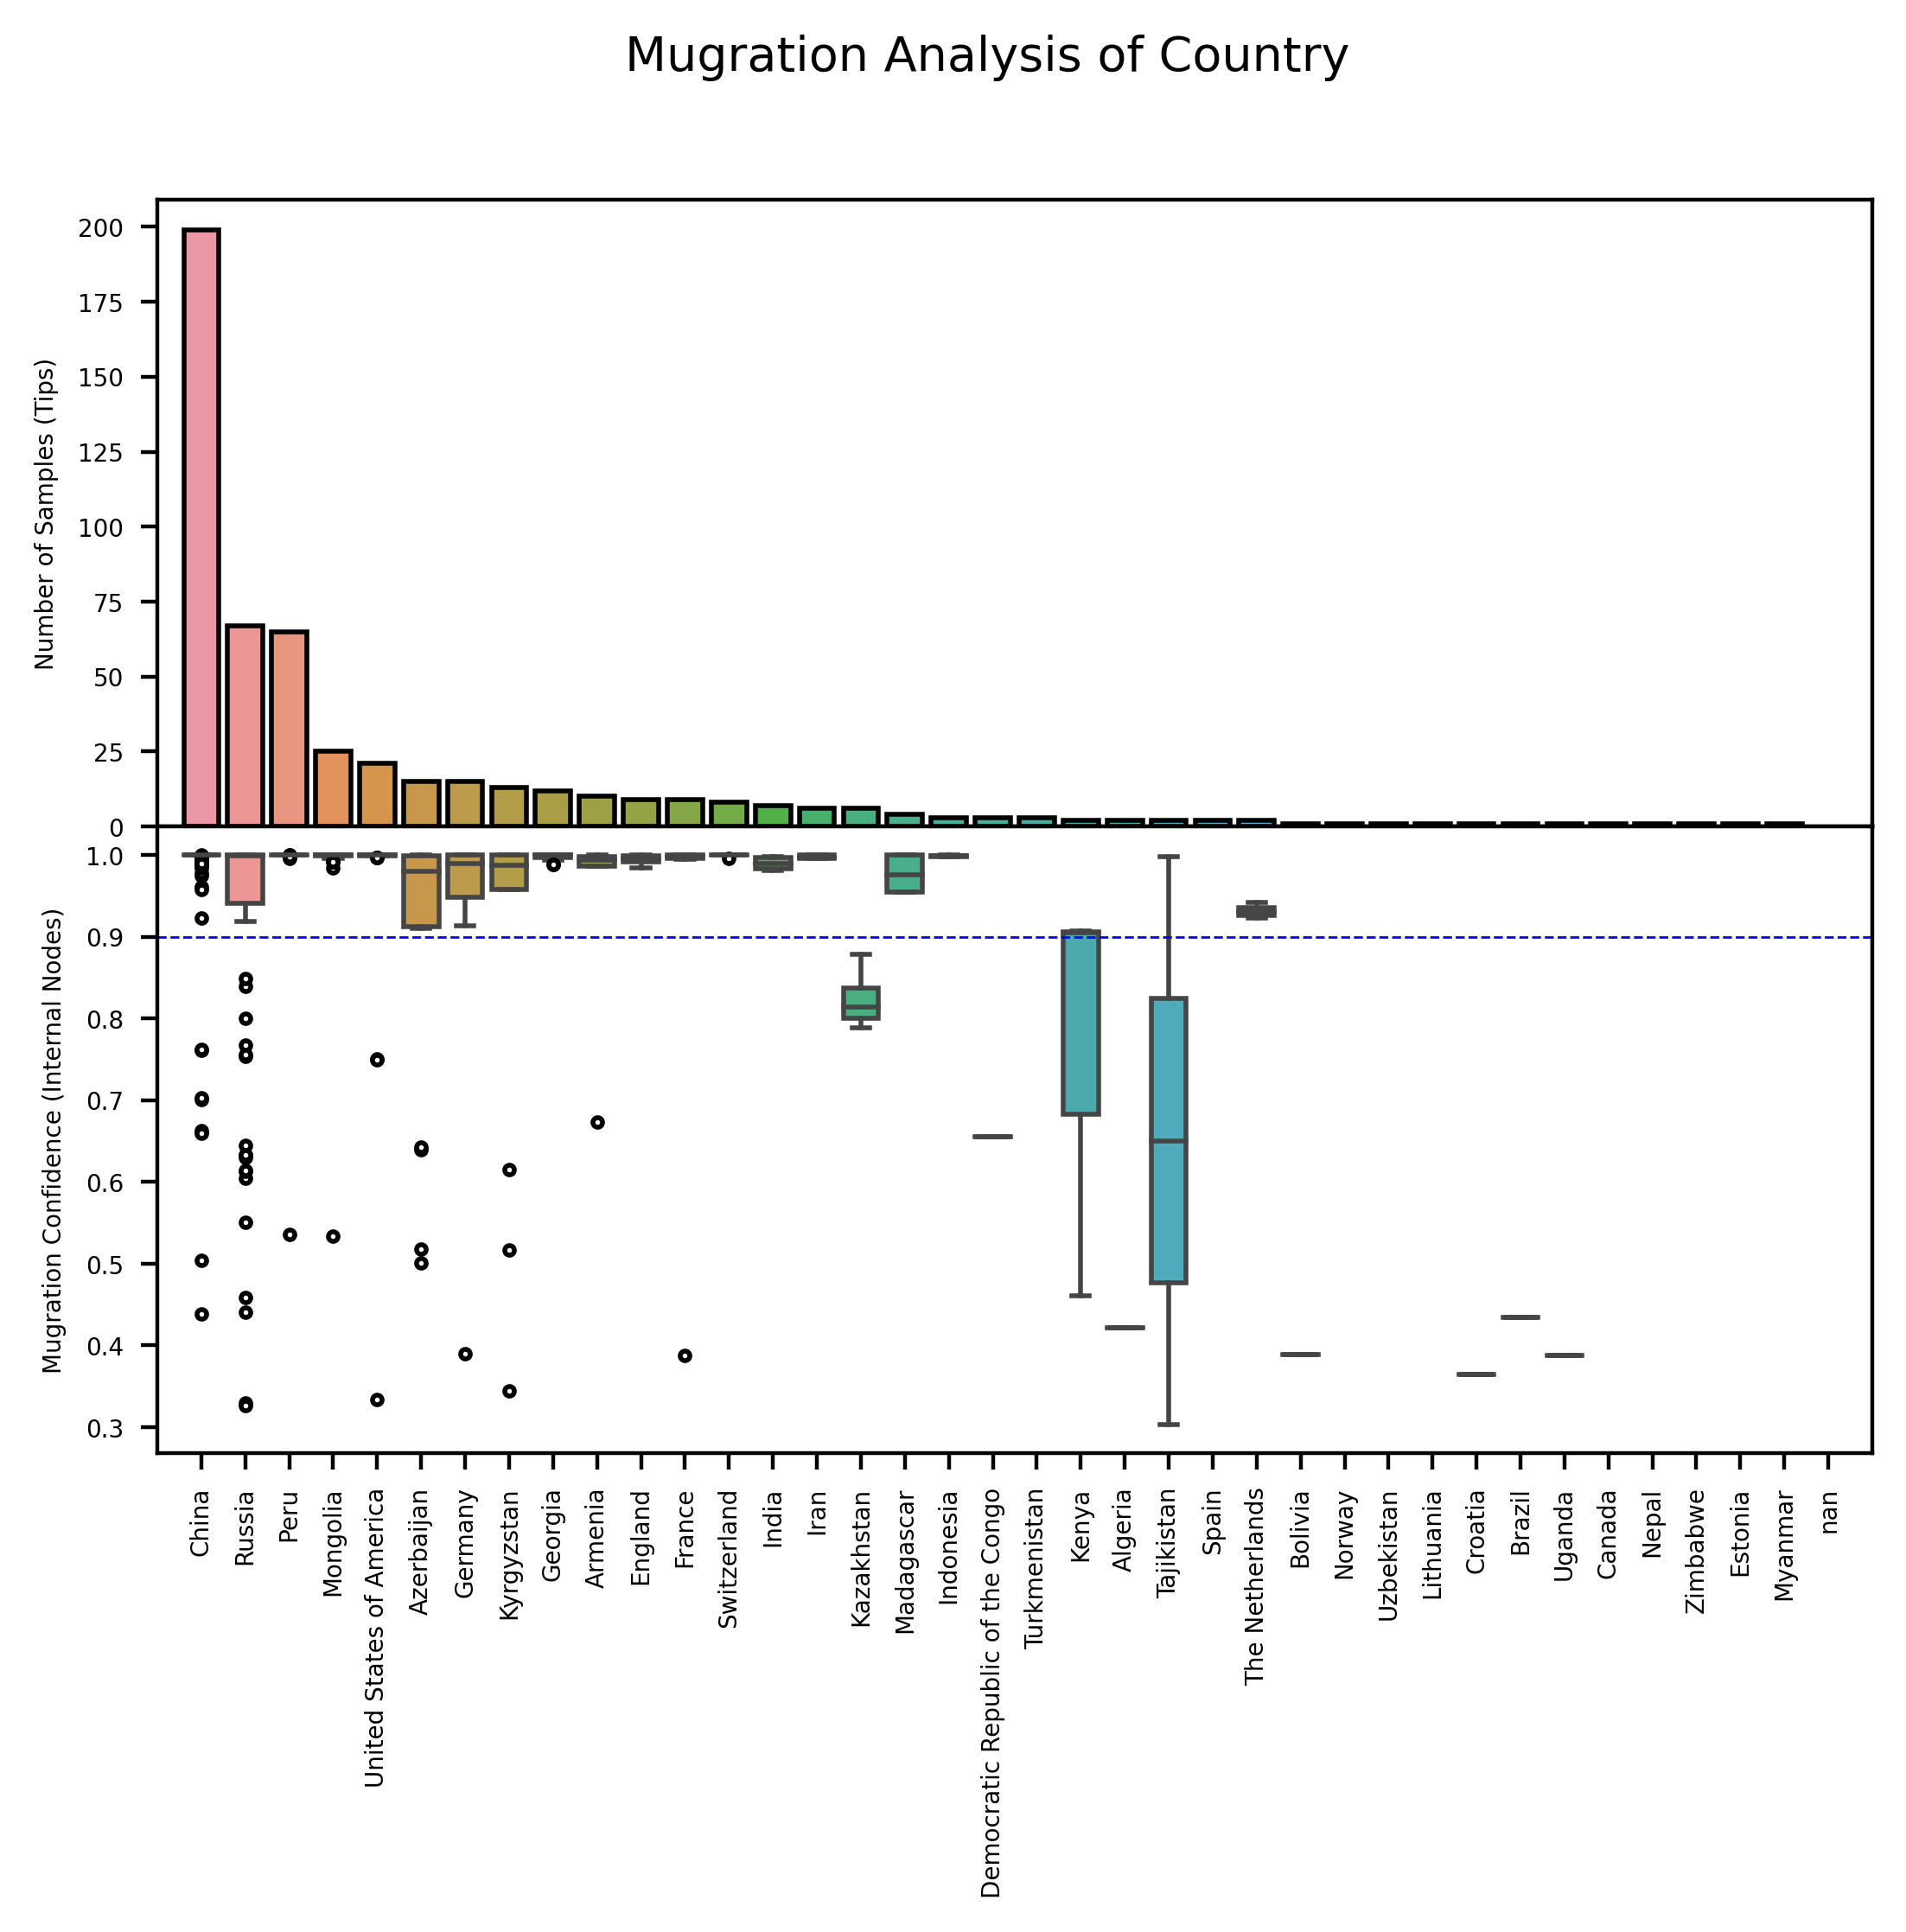

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 
                               sharex=False, 
                               gridspec_kw={'hspace': 0},
                               figsize=figsize, 
                               dpi=dpi,
                               #constrained_layout=True,
                              )

# --------------------------
# Axis 1 - Sampling Location
# Exclude samples with no attribute recorded
data = tree_df[tree_df[ATTRIBUTE] != "NA"]
label_order = list(data[ATTRIBUTE].value_counts().index)
label_order = [lab for lab in label_order if lab != "nan"] + ["nan"]
sns.countplot(data=data, 
              x=ATTRIBUTE, 
              #color="blue", 
              edgecolor="black",
              ax=ax1, 
              order=label_order)
plt.setp(ax1.get_xticklabels(), visible=False)
xticklabels = [item.get_text() for item in ax1.get_xticklabels()]
ax1.set_xticklabels(xticklabels, rotation = 90, ha="right")
ax1.set_xlabel("")
ax1.set_ylabel("Number of Samples (Tips)")
ax1.set_xlim(-1,len(label_order))

# --------------------------
# Axis 2 - Mugration Confidence
# Exclude nodes that are terminals (ie. branch support is grey)
data = tree_df[tree_df["Branch_Support_Color"] != "grey"]
flierprops = dict(marker='o', markerfacecolor='white', markersize=2,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(data=data, 
              x="Mugration_" + ATTRIBUTE, 
              y="Mugration_" + ATTRIBUTE + "_Confidence",
              #color="blue", 
              ax=ax2, 
              order=label_order,
              flierprops=flierprops)
#plt.setp(ax2.get_xticklabels(), visible=False)
xticklabels = [item.get_text() for item in ax2.get_xticklabels()]
ax2.set_xticklabels(xticklabels, rotation = 90, ha="center")
ax2.axhline(y=MUG_CONF_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
ax2.set_xlabel("")
ax2.set_ylabel("Mugration Confidence (Internal Nodes)")
ax2.set_xlim(-1,len(label_order))

fig.suptitle("Mugration Analysis of {}".format(ATTRIBUTE))

out_path = os.path.join(outdir, "treetime_{}_mug.jpg".format(ATTRIBUTE.lower())) 
plt.savefig(out_path, 
            dpi=400, 
            bbox_inches = "tight")

### Plot Confidence Regression

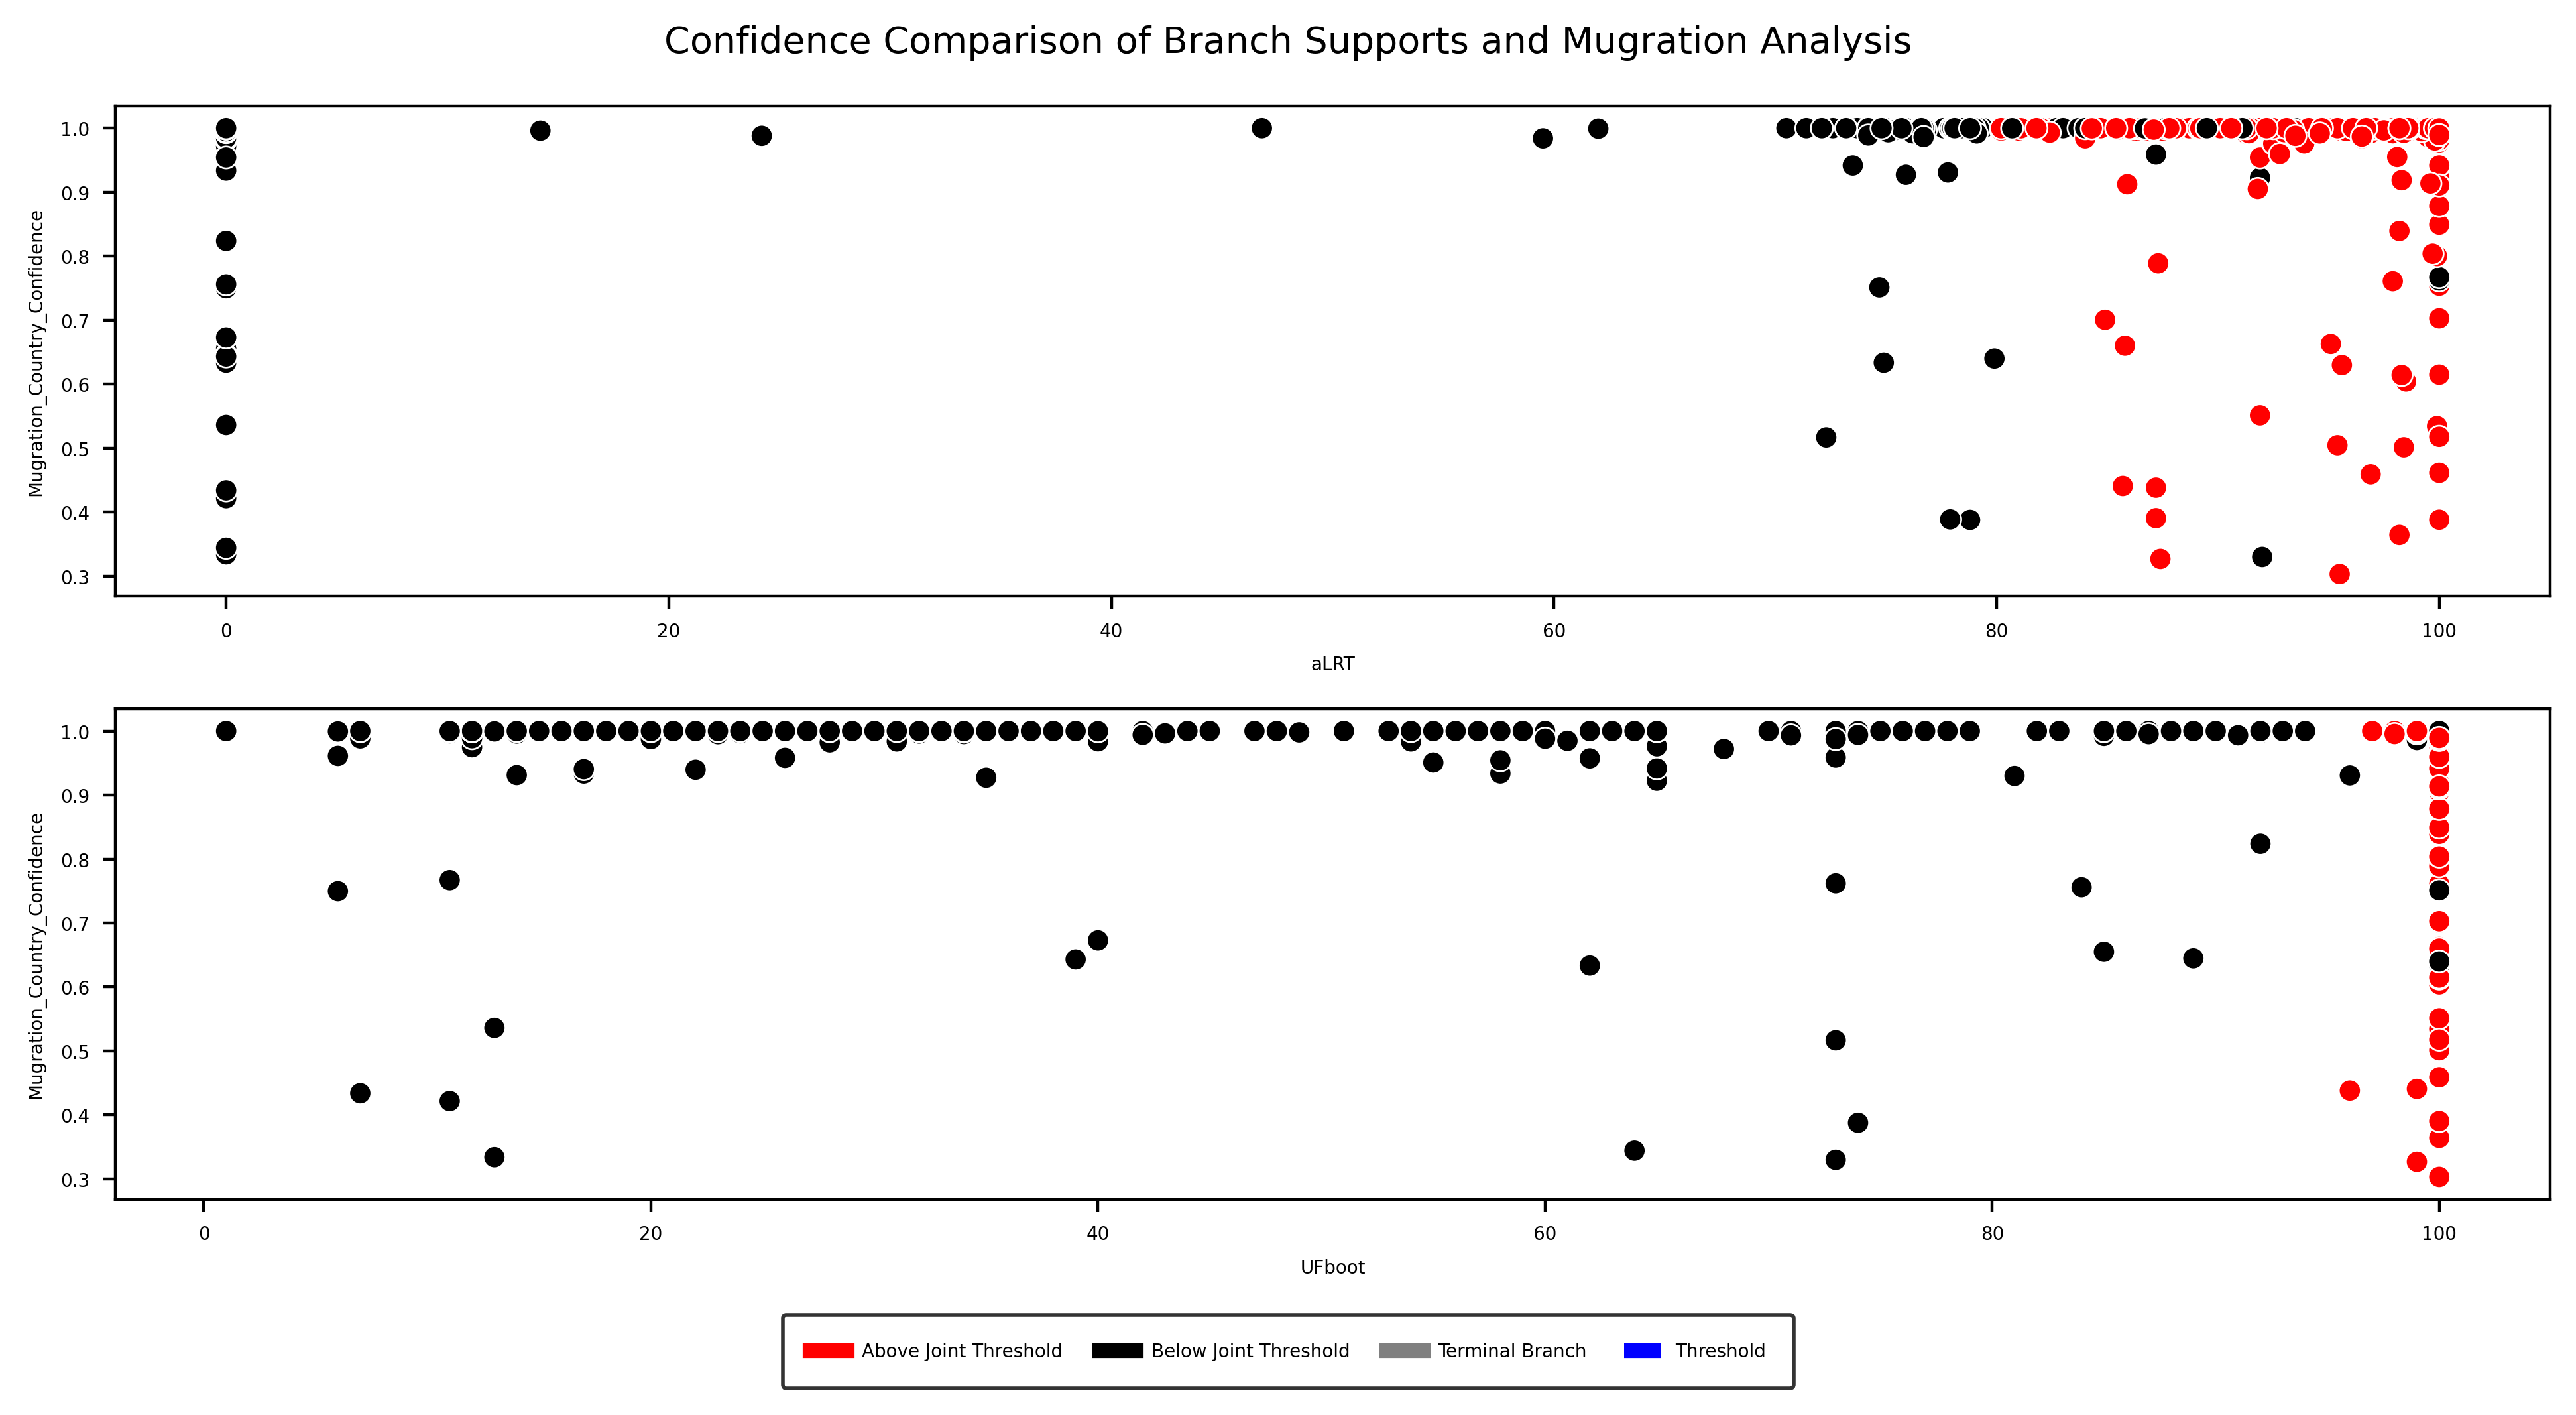

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 
                               sharey=True, 
                               gridspec_kw={'hspace': 0},
                               figsize=figsize_alt, 
                               dpi=dpi,
                               constrained_layout=True,
                              )


# --------------------------
# Axis 1 - Regression of Mugration vs. UFboot
# Exclude nodes that are terminals (ie. branch support is grey)
data = tree_df[tree_df["Branch_Support_Color"] != "grey"]
sns.scatterplot(data=data, 
            x="aLRT", 
            y="Mugration_" + ATTRIBUTE + "_Confidence",
            ax=ax1, 
            hue="Branch_Support_Color",
            palette=[LOW_COL, HIGH_COL],
            legend=False)
sns.scatterplot(data=data, 
            x="UFboot",
            y="Mugration_" + ATTRIBUTE + "_Confidence",
            ax=ax2, 
            hue="Branch_Support_Color",
            palette=[LOW_COL, HIGH_COL],
            legend=False,
            )

#ax1.set_ylabel("Mugration Confidence (Internal Nodes)")

# Legend
legend_lines = [lines.Line2D([0], [0], color=HIGH_COL, lw=4),
                lines.Line2D([0], [0], color=LOW_COL, lw=4),
                lines.Line2D([0], [0], color=TERM_COL, lw=4),
                lines.Line2D([0], [0], color=THRESH_COL, lw=4, ls="--"),
               ]

legend_labels = ["Above Joint Threshold",
                 "Below Joint Threshold",
                 "Terminal Branch",
                 "Threshold"]
fig.legend(legend_lines, 
           legend_labels,
           ncol=len(legend_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.05),
           frameon=True,
           borderpad=1.5,
           edgecolor="black") 

fig.suptitle("Confidence Comparison of Branch Supports and Mugration Analysis".format(ATTRIBUTE))

out_path = os.path.join(outdir, "treetime_{}_mug_vs_branch-support.jpg".format(ATTRIBUTE.lower())) 
plt.savefig(out_path, 
            dpi=400, 
            bbox_inches = "tight")

### Draw Mugration Tree

In [16]:
"""# Make a copy of the tree to edit values
mug_tree_div = copy.deepcopy(mug.tree)
# Deepest nodes first
mug_tree_div.ladderize(reverse=False)

# Initialize the states with the low confidence 
ordered_states = ["Low Confidence"]

# Get the ladderized order of attributes
for t in mug_tree_div.get_terminals():
    for prop in t.other:
        if prop.namespace == ATTRIBUTE + "_assign" and prop.tag not in ordered_states:
            ordered_states.append(prop.tag)

# Number of states that need colors (exclude nan)
num_attr = len(unique_states[:-1])

# Create the custom color map
cmap = plt.get_cmap(COLOR_PAL,num_attr)
# Convert to a list of colors
cmaplist = [cmap(i) for i in range(cmap.N)]

# force the first color entry to be grey
cmaplist = [(.5, .5, .5, 1.0)] + cmaplist 
num_attr = num_attr + 1

# create the new map
cmap = colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, num_attr)

cmaplist = cmap(np.linspace(0, 1, num_attr))
hex_list = [colors.to_hex(col) for col in cmaplist]

hex_dict = {}

# Assign states colors based on tip order (Low Conf first as grey)
for state,hex_col in zip(ordered_states, hex_list):
    print(state,hex_col)
    hex_dict[state] = hex_col

# Deepest nodes last
mug_tree_div.ladderize(reverse=True)

# Color branches by attr
for c in mug_tree_div.find_clades():
    for prop in c.other:
        if prop.namespace == ATTRIBUTE + "_assign":
            # Color by category
            c.color = hex_dict[prop.tag]
"""

'# Make a copy of the tree to edit values\nmug_tree_div = copy.deepcopy(mug.tree)\n# Deepest nodes first\nmug_tree_div.ladderize(reverse=False)\n\n# Initialize the states with the low confidence \nordered_states = ["Low Confidence"]\n\n# Get the ladderized order of attributes\nfor t in mug_tree_div.get_terminals():\n    for prop in t.other:\n        if prop.namespace == ATTRIBUTE + "_assign" and prop.tag not in ordered_states:\n            ordered_states.append(prop.tag)\n\n# Number of states that need colors (exclude nan)\nnum_attr = len(unique_states[:-1])\n\n# Create the custom color map\ncmap = plt.get_cmap(COLOR_PAL,num_attr)\n# Convert to a list of colors\ncmaplist = [cmap(i) for i in range(cmap.N)]\n\n# force the first color entry to be grey\ncmaplist = [(.5, .5, .5, 1.0)] + cmaplist \nnum_attr = num_attr + 1\n\n# create the new map\ncmap = colors.LinearSegmentedColormap.from_list(\n    \'Custom cmap\', cmaplist, num_attr)\n\ncmaplist = cmap(np.linspace(0, 1, num_attr))\nhex_lis

In [17]:
"""# Draw the tree
# ----------------------------------
# Deepest nodes last
mug_tree_div.ladderize(reverse=True)

fig = plt.figure(dpi=400)
ax = plt.subplot()

# Draw tree to the canvas
Phylo.draw(mug_tree_div, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# Root branch length set to 0.001
ax.set_xlim(0.000999,0.00108)
ax.set_ylim(-20,len(mug_tree_div.get_terminals())+20)
ax.set_yticks([])
#ax.set_xticks([])

# Create the colorbar
norm = colors.Normalize(vmin=0.5,vmax=num_attr + 0.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(1,num_attr,num_attr))
# Add conf info to Low conf label
#ordered_states[0] = "Low Confidence \n (confidence < {})".format(MUG_CONF_THRESH)
ordered_states[0] = "Low Confidence"
cbar.ax.set_yticklabels(ordered_states) 

plt.xlabel("Branch Length")
plt.ylabel("Taxa")
plt.title("Treetime Mugration: {}".format(ATTRIBUTE))
out_path = os.path.join(outdir, "treetime_{}_mug_tree.jpg".format(ATTRIBUTE.lower()))  
plt.savefig(out_path, dpi=400, bbox_inches = "tight")

# Write Tree File
out_path = os.path.join(outdir, "treetime_{}_mug_tree.xml".format(ATTRIBUTE.lower() ))
Phylo.write(mug_tree_div, 
            out_path,
            "phyloxml")"""

'# Draw the tree\n# ----------------------------------\n# Deepest nodes last\nmug_tree_div.ladderize(reverse=True)\n\nfig = plt.figure(dpi=400)\nax = plt.subplot()\n\n# Draw tree to the canvas\nPhylo.draw(mug_tree_div, \n           axes=ax, \n           show_confidence=False, \n           label_func = lambda x:\'\', \n           do_show=False)\n\n# Root branch length set to 0.001\nax.set_xlim(0.000999,0.00108)\nax.set_ylim(-20,len(mug_tree_div.get_terminals())+20)\nax.set_yticks([])\n#ax.set_xticks([])\n\n# Create the colorbar\nnorm = colors.Normalize(vmin=0.5,vmax=num_attr + 0.5)\nsm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)\nsm.set_array([])\ncbar = plt.colorbar(sm, ticks=np.linspace(1,num_attr,num_attr))\n# Add conf info to Low conf label\n#ordered_states[0] = "Low Confidence \n (confidence < {})".format(MUG_CONF_THRESH)\nordered_states[0] = "Low Confidence"\ncbar.ax.set_yticklabels(ordered_states) \n\nplt.xlabel("Branch Length")\nplt.ylabel("Taxa")\nplt.title("Treetime Mugratio

### Draw Mugration Confidence Tree

In [18]:
"""# Deepest nodes last
mug_tree_div.ladderize(reverse=True)

for c in mug_tree_div.find_clades():
    for prop in c.other:
        if prop.namespace == ATTRIBUTE + "_assign":
            # color by confidence
            c.color = "black"
            if float(prop.value) >= MUG_CONF_THRESH:
                c.color = "red"

fig = plt.figure(dpi=400)
ax = plt.subplot()

# Draw tree to the canvas
Phylo.draw(mug_tree_div, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# Root branch length set to 0.001
# Ticks
ax.set_xlim(0.000999,0.00108)
ax.set_ylim(-20,len(mug_tree_div.get_terminals())+20)
ax.set_yticks([])
plt.xticks(fontsize=7)

# Labels
plt.xlabel("Branch Length")
plt.ylabel("Taxa")
plt.title("Mugration {} Confidence".format(ATTRIBUTE))

# Legend
legend_lines = [lines.Line2D([0], [0], color="red", lw=4),
                lines.Line2D([0], [0], color="black", lw=4)]

ax.legend(legend_lines, 
          ["High Confidence)".format(MUG_CONF_THRESH),
           "Low Confidence"],
          bbox_to_anchor=(1.0, 1.0), 
          loc='upper left',)

# Write to file
out_path = os.path.join(outdir, "treetime_{}_mug_conf_tree.jpg".format(ATTRIBUTE.lower()))  
plt.savefig(out_path, dpi=400, bbox_inches = "tight")"""

'# Deepest nodes last\nmug_tree_div.ladderize(reverse=True)\n\nfor c in mug_tree_div.find_clades():\n    for prop in c.other:\n        if prop.namespace == ATTRIBUTE + "_assign":\n            # color by confidence\n            c.color = "black"\n            if float(prop.value) >= MUG_CONF_THRESH:\n                c.color = "red"\n\nfig = plt.figure(dpi=400)\nax = plt.subplot()\n\n# Draw tree to the canvas\nPhylo.draw(mug_tree_div, \n           axes=ax, \n           show_confidence=False, \n           label_func = lambda x:\'\', \n           do_show=False)\n\n# Root branch length set to 0.001\n# Ticks\nax.set_xlim(0.000999,0.00108)\nax.set_ylim(-20,len(mug_tree_div.get_terminals())+20)\nax.set_yticks([])\nplt.xticks(fontsize=7)\n\n# Labels\nplt.xlabel("Branch Length")\nplt.ylabel("Taxa")\nplt.title("Mugration {} Confidence".format(ATTRIBUTE))\n\n# Legend\nlegend_lines = [lines.Line2D([0], [0], color="red", lw=4),\n                lines.Line2D([0], [0], color="black", lw=4)]\n\nax.legen

## Questions

### 1. How much phylogenetic signal is present in the *Yersinia pestis* phylogeny?

1

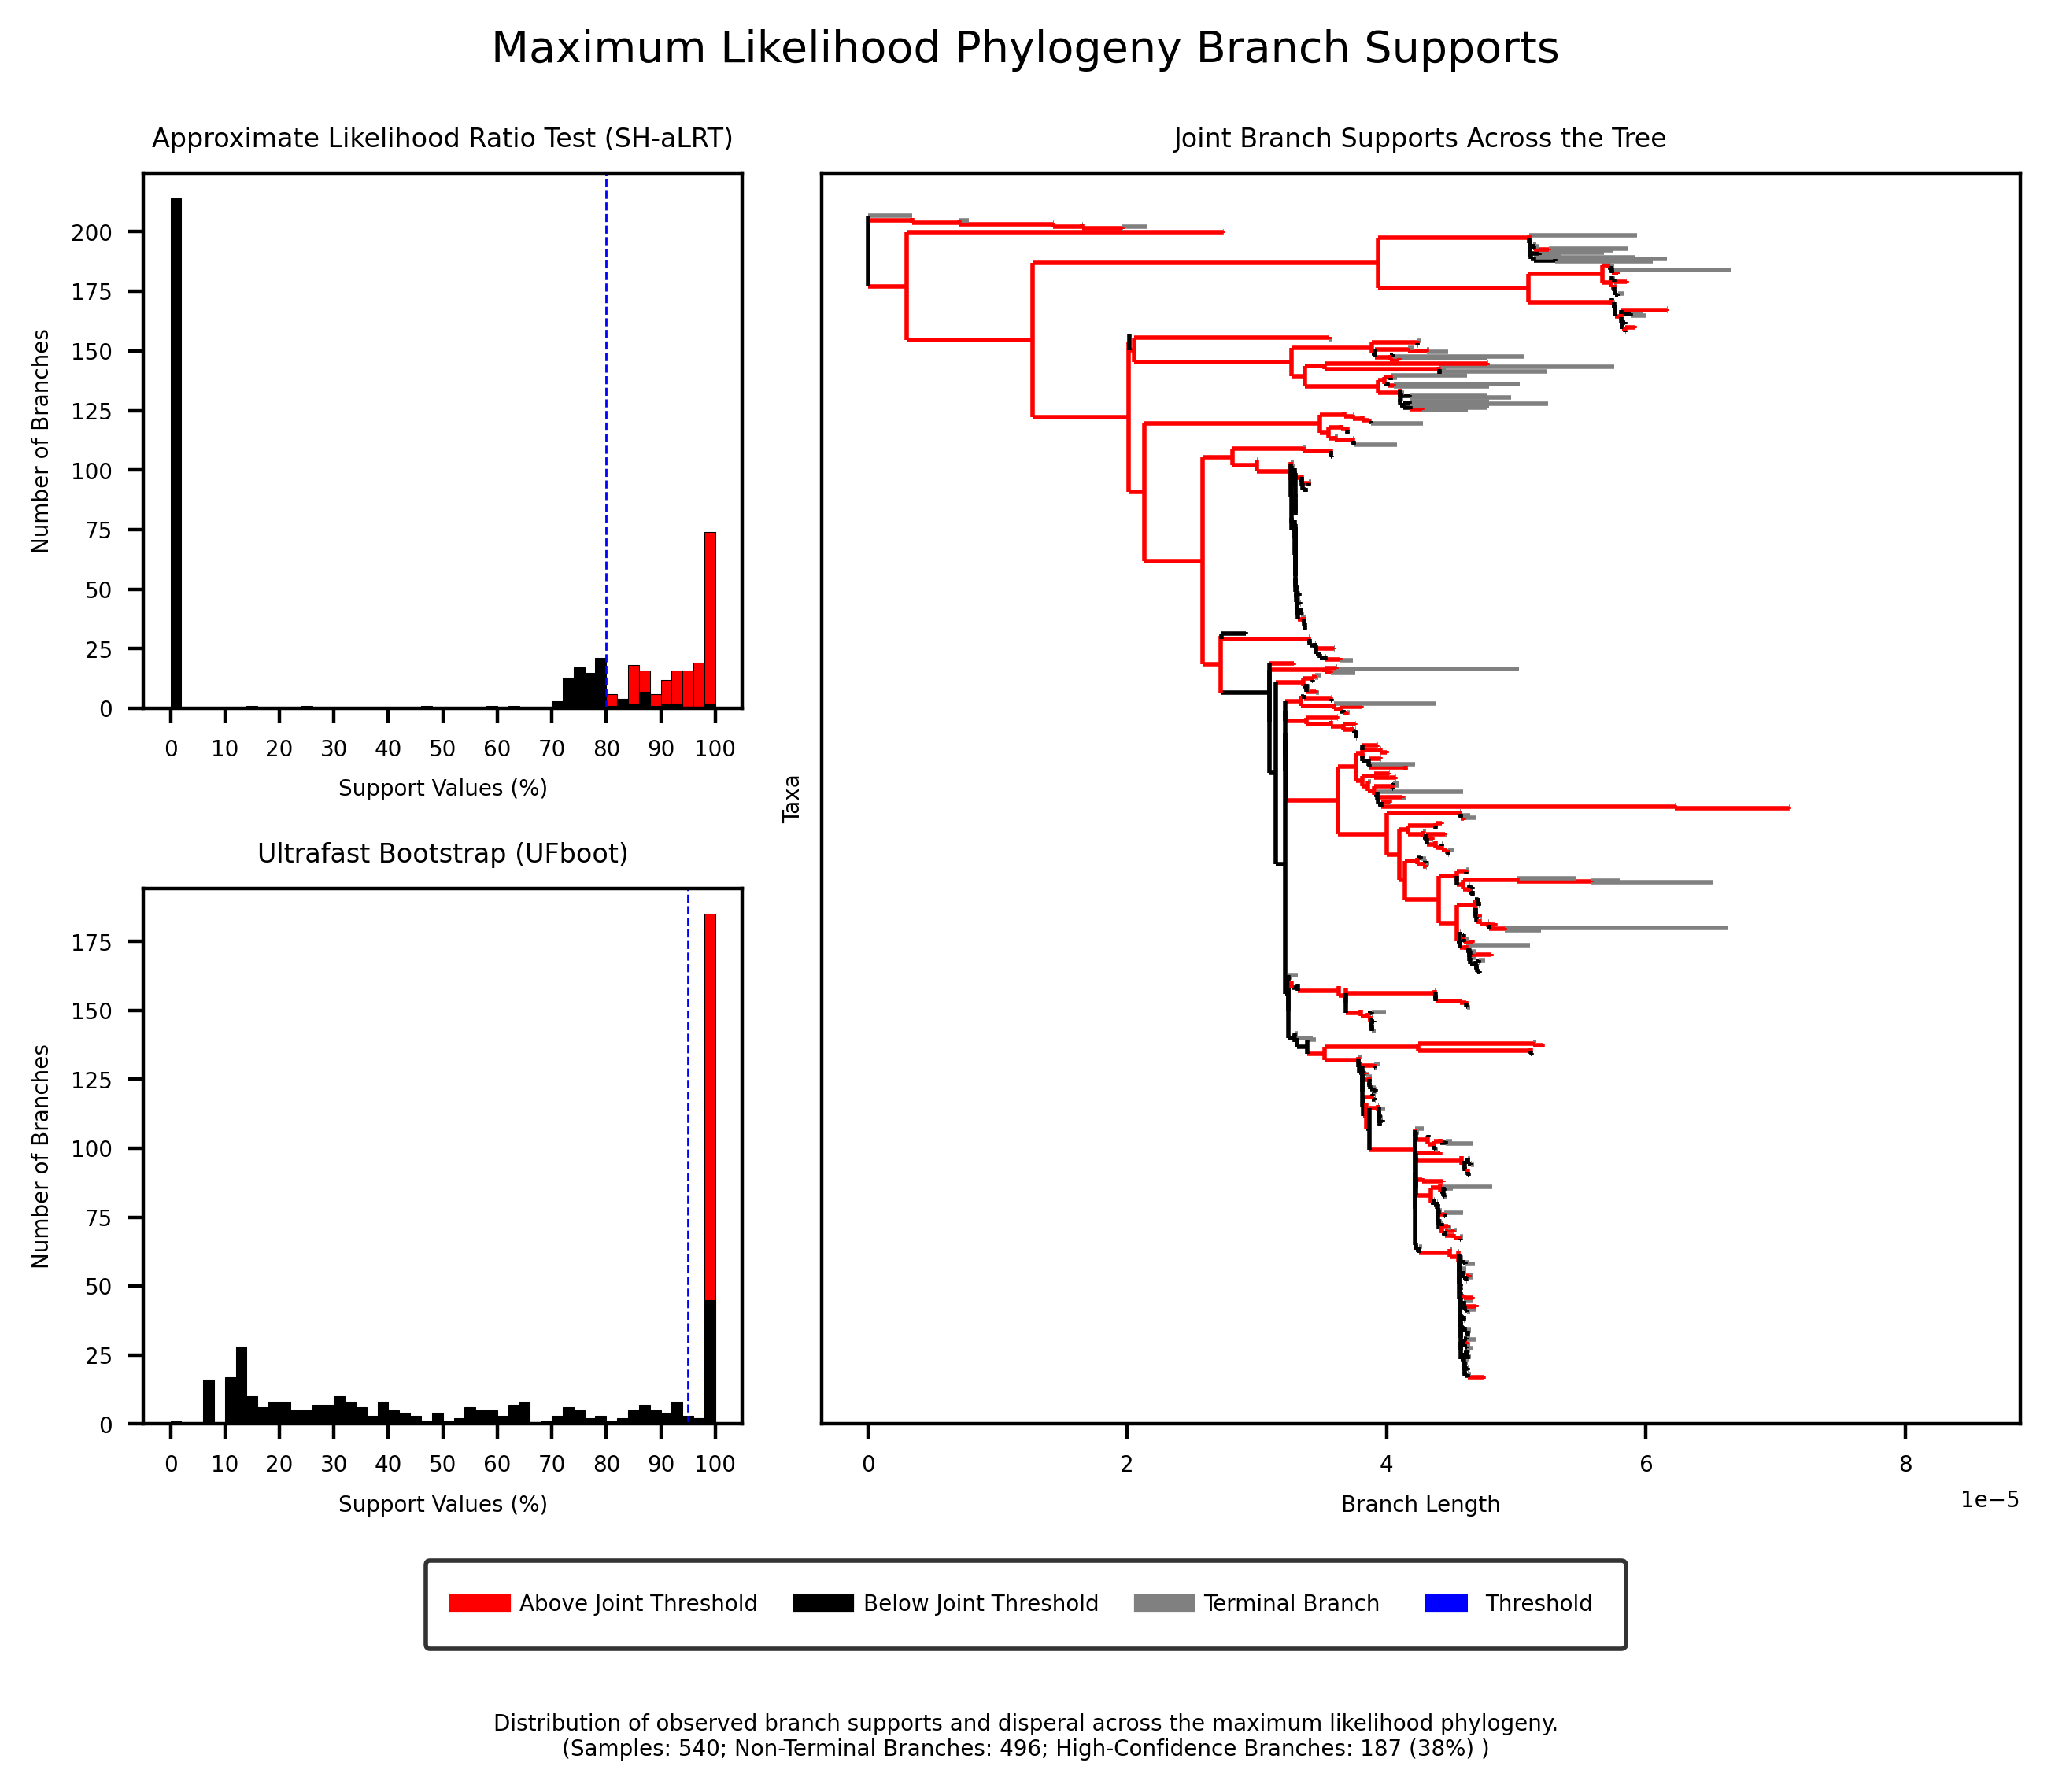

In [54]:
fig = plt.figure(constrained_layout=True, 
                 dpi=dpi,
                 figsize=figsize)

# Setup the grid
gs = gridspec.GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0:, 1:3])

# Local plot variables
hist_bins = [x for x in range(0,101,2)]
xticks_major = [x for x in range(0,101,10)]

# Filter out NA values
data = tree_df[(tree_df['aLRT'] != "NA") & (tree_df['UFboot'] != "NA") ]

# -------------------------------
# aLRT Axis
sns.histplot(data, 
             x="aLRT", 
             ax=ax1,
             bins=hist_bins,
             hue="Branch_Support_Color",
             palette=[LOW_COL, HIGH_COL],
             legend=False,
             alpha=1)
ax1.axvline(x=ALRT_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
ax1.set_xticks(xticks_major, minor=False)
ax1.set_xticklabels(xticks_major)
ax1.set_xlabel("Support Values (%)")
ax1.set_ylabel('Number of Branches')
ax1.set_title('Approximate Likelihood Ratio Test (SH-aLRT)')

# -------------------------------
# UFboot Axis
sns.histplot(data, 
             x="UFboot", 
             ax=ax2,
             bins=hist_bins,
             hue="Branch_Support_Color",
             palette=[LOW_COL, HIGH_COL],
             legend=False,
             alpha=1)
ax2.axvline(x=UFBOOT_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
ax2.set_xticks(xticks_major, minor=False)
ax2.set_xticklabels(xticks_major)
ax2.set_ylabel('Number of Branches')
ax2.set_xlabel("Support Values (%)")
ax2.set_title('Ultrafast Bootstrap (UFboot)')

# -------------------------------
# Phylogeny
tree_div.ladderize(reverse=True)
Phylo.draw(tree_div,
           axes=ax3,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)
ax3.set_xlabel('Branch Length')
ax3.set_ylabel('Taxa')
ax3.set_yticks([])
ax3.set_yticklabels([])
ax3.set_ylim(-20,len(tree_div.get_terminals())+20)
ax3.set_title("Joint Branch Supports Across the Tree")

# -------------------------------
# Figure title
fig.suptitle("Maximum Likelihood Phylogeny Branch Supports")

# -------------------------------
# Legend
legend_lines = [lines.Line2D([0], [0], color=HIGH_COL, lw=4),
                lines.Line2D([0], [0], color=LOW_COL, lw=4),
                lines.Line2D([0], [0], color=TERM_COL, lw=4),
                lines.Line2D([0], [0], color=THRESH_COL, lw=4, ls="--"),
               ]

legend_labels = ["Above Joint Threshold",
                 "Below Joint Threshold",
                 "Terminal Branch",
                 "Threshold"]
fig.legend(legend_lines, 
           legend_labels,
           ncol=len(legend_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.05),
           frameon=True,
           borderpad=1.5,
           edgecolor="black") 

# -------------------------------
# Caption
num_terminal_nodes = len(tree_df[tree_df["Branch_Support_Color"] == TERM_COL])
num_internal_nodes = len(tree_df[tree_df["Branch_Support_Color"] != TERM_COL])
num_high_support = len(tree_df[tree_df["Branch_Support_Color"] == HIGH_COL])
num_low_support = len(tree_df[tree_df["Branch_Support_Color"] == LOW_COL])
perc_high_support = (num_high_support / num_internal_nodes) * 100

caption_text = ("Distribution of observed branch supports and disperal across the maximum likelihood phylogeny." 
                + "\n(" 
                + "Samples: {}".format(num_terminal_nodes) 
                + "; "
                + "Non-Terminal Branches: {}".format(num_internal_nodes)
                + "; "
                + "High-Confidence Branches: {0} ({1:.0f}%)".format(num_high_support, perc_high_support)
                + " )"
               )
fig.text(0.5, -0.15, caption_text, ha='center')

# -------------------------------
# Save figure
out_path = os.path.join(outdir, "treetime_branch-support.jpg") 
plt.savefig(out_path, dpi=400, bbox_inches = "tight")

# Save Tree File
out_path = os.path.join(outdir, "treetime_branch-support.xml" )
Phylo.write(tree_div, 
            out_path,
            "phyloxml")

### 2. How much phylogeographic signal is present in the *Yersinia pestis* phylogeny?

In [52]:
# Store terminals in two lists for comparison
term_list = [t for t in tree_div.get_terminals()]
term_list.reverse()

dist_div_list = []
dist_geo_list = []

i = 0
progress_log_breaks = [num for num in range(0,101)]
i_progress = 0

for t1 in term_list:
    
    t1_name = t1.name
    t1_lat = tree_df[ATTRIBUTE_LAT][t1.name]
    t1_lon = tree_df[ATTRIBUTE_LON][t1.name]
    t1_latlon = (t1_lat, t1_lon)
    
    # Skip if natlon is nan
    if t1_lat == "NA" or t1_lon == "NA":
        continue
        
    # Iterate through terminals again for distance measures
    for t2 in term_list:           
        t2_name = t2.name     
        # Skip if it's a self comparison
        if t1_name == t2_name: continue
            
        t2_lat = tree_df[ATTRIBUTE_LAT][t2_name]
        t2_lon = tree_df[ATTRIBUTE_LON][t2_name]
        
        # Skip if latlon is nan
        if t2_lat == "NA" or t2_lon == "NA":
            continue
        t2_latlon = (t2_lat, t2_lon)
       
        # Calculate branch distance (divergence)
        dist_div = tree_div.distance(t1_name, t2_name)  
        # Calculate geographic distance (great circle)
        dist_geo = getattr(great_circle(t1_latlon, t2_latlon), DIST_UNIT)
        dist_div_list.append(dist_div)
        dist_geo_list.append(dist_geo)
    
    # Counter for a progress log since this is slow
    i+=1
    progress = (i / len(term_list)) * 100
    if progress >= progress_log_breaks[i_progress]:
        print("{:0.0f}%".format(progress))
        i_progress += 1
    #if i ==5:
    #    break

0%
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%


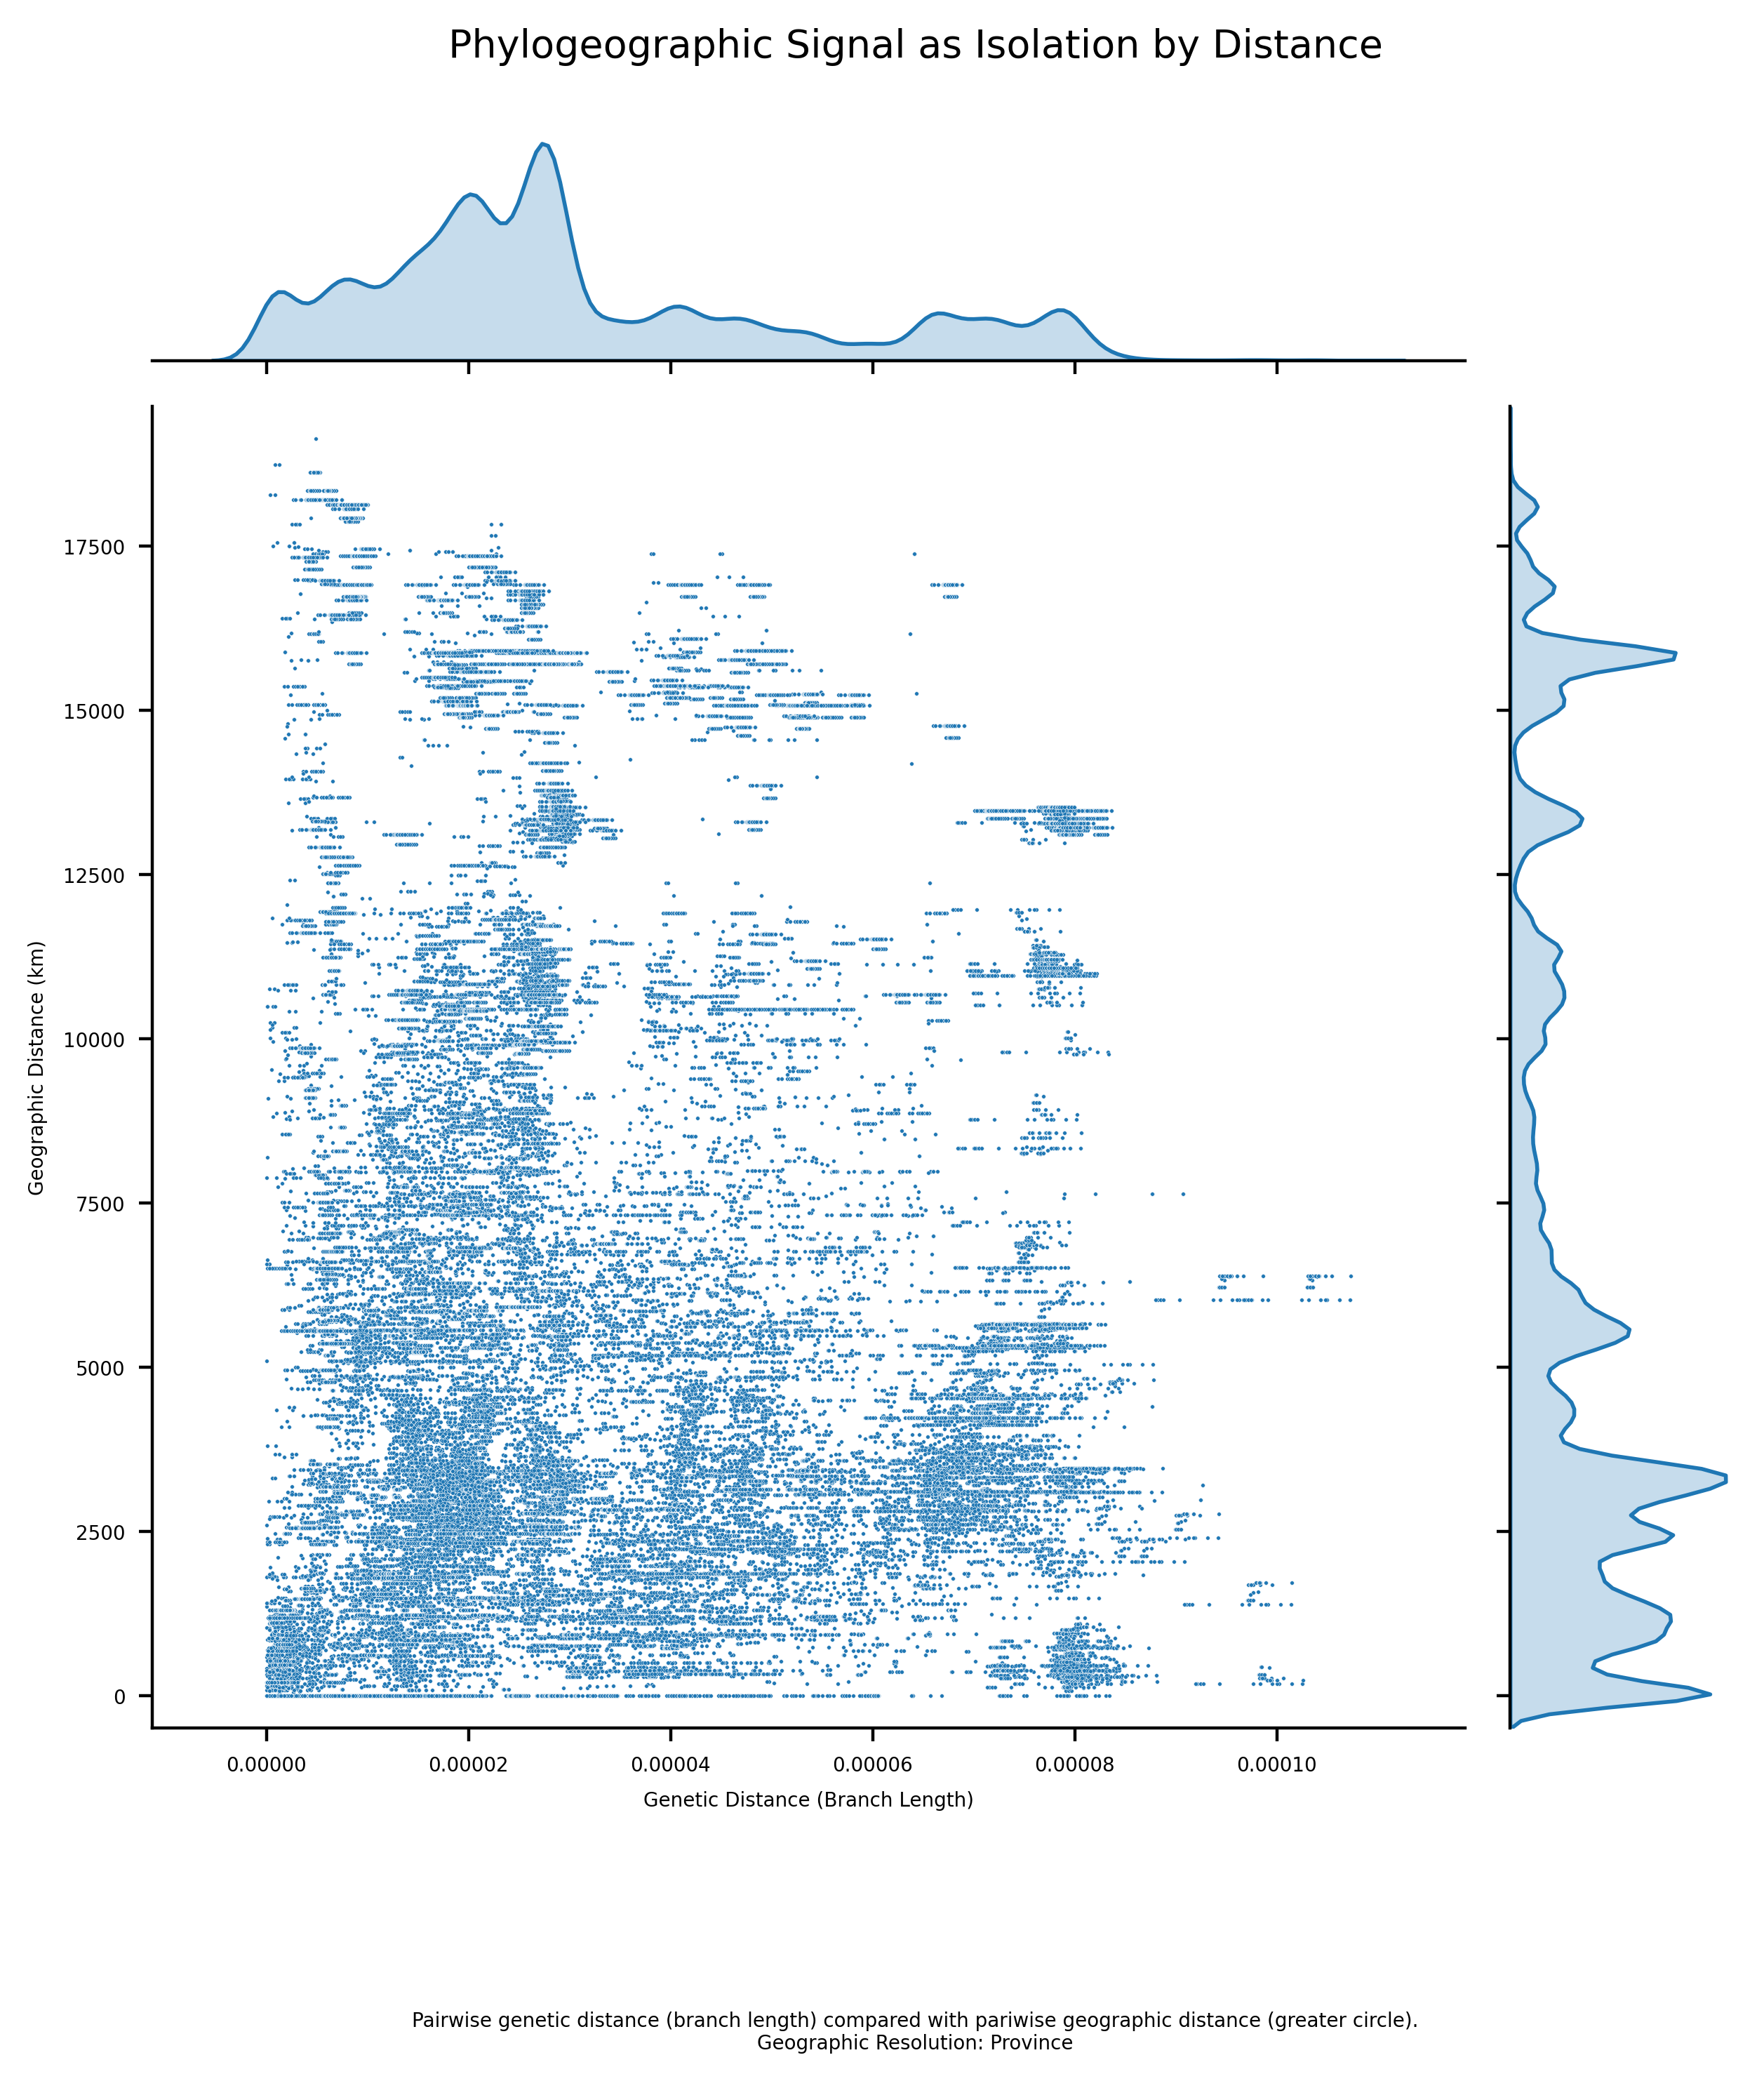

In [58]:
# Create a joint plot

g = sns.JointGrid()
g.fig.set_dpi(dpi)

# Main Scatter
#sns.regplot(
sns.scatterplot(
                x=dist_div_list,
                y=dist_geo_list,  
                s=1,
                #scatter_kws = {"s": 0.5}, 
                ax=g.ax_joint,
                #line_kws={"color": "red"}
               )

sns.kdeplot(x=dist_div_list, 
            linewidth=1,
            fill=True,
            ax=g.ax_marg_x,
            #bw_method=0.03,
           )

sns.kdeplot(y=dist_geo_list, 
            linewidth=1,
            fill=True,
            ax=g.ax_marg_y,
            bw_method=0.03,
           )

# Constrain view and limits
g.ax_marg_y.set_ylim(0-500,int(max(dist_geo_list)) + 500)

# Labels and Titles
g.ax_joint.set_xlabel("Genetic Distance (Branch Length)")
g.ax_joint.set_ylabel("Geographic Distance (km)")
g.fig.suptitle("Phylogeographic Signal as Isolation by Distance",
                x=0.5,
                y=1.05)

# Caption
caption_text = ("Pairwise genetic distance (branch length) compared with pariwise geographic distance (greater circle)." 
                + "\nGeographic Resolution: {}".format(ATTRIBUTE)
               )
g.fig.text(0.5, 0, caption_text, ha='center')

# Save
out_path = os.path.join(outdir, "treetime_{}_IBD.jpg".format(ATTRIBUTE.lower())) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

## Cleanup

In [22]:
os.remove(tmp_xml)